In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stumpy as sp
import librosa
import librosa.display
from scipy.io import wavfile
import os
import json
import soundfile as sf
import warnings
warnings.filterwarnings('ignore')
import timeit


# Questions

- should backround noise be removed? or would building a model able to deal with backround noise be more scalable.

- it has been proven in forecasting applications (charles shwab), but is matrix profiling a viable **sound processing** technique at scale?

- can the matrix profile values themselves be used inherently to classify species? or must they be input to a model

## Read In Data

get metadata, and bird for prediction (20) to select the highest quality recording as a reference for making predictions.


In [354]:
#birds_list = json.loads('./data/birdclef-2022/scored_birds.json')
train_metadata = pd.read_csv('./data/birdclef-2022/train_metadata.csv')

birds_list = ["akiapo", "aniani", "apapan", "barpet", "crehon", "elepai", "ercfra", "hawama", "hawcre", "hawgoo", "hawhaw", "hawpet1", "houfin", "iiwi", "jabwar", "maupar", "omao", "puaioh", "skylar", "warwhe1", "yefcan"]

will analyze the metadata for the 20 birds of focus, and select the highest quality recording for them, for call, song, or another sound if call or song isn't also present for that recording

In [355]:
train_metadata.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [356]:
train_metadata.shape

(14852, 13)

In [357]:
df = train_metadata[train_metadata['primary_label'].isin(birds_list)]

In [358]:
df.shape
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
32,akiapo,"['apapan', 'hawama', 'iiwi']",['song'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,12:31,https://www.xeno-canto.org/122399,akiapo/XC122399.ogg
33,akiapo,"['apapan', 'iiwi', 'warwhe1']",['call'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,17:46,https://www.xeno-canto.org/122401,akiapo/XC122401.ogg
34,akiapo,['apapan'],['song'],19.6642,-155.3896,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,16:22,https://www.xeno-canto.org/122693,akiapo/XC122693.ogg
35,akiapo,"['apapan', 'elepai', 'hawama', 'iiwi', 'omao',...",['call'],19.6642,-155.3896,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,3.5,15:58,https://www.xeno-canto.org/124705,akiapo/XC124705.ogg
36,akiapo,"['apapan', 'hawama', 'iiwi', 'omao', 'warwhe1']",['song'],19.6334,-155.3753,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,2.5,14:43,https://www.xeno-canto.org/124801,akiapo/XC124801.ogg


Remove recordings where there's a secondary label'

In [359]:
df = df[df['secondary_labels'] == '[]']
df.head(10)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
39,akiapo,[],['begging call (?)'],19.7901,-155.3273,Hemignathus wilsoni,Akiapolaau,Daniel Lane,Creative Commons Attribution-NonCommercial-Sha...,4.0,15:40,https://www.xeno-canto.org/27355,akiapo/XC27355.ogg
42,akiapo,[],['song'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,George Wagner,Creative Commons Attribution-NonCommercial-Sha...,5.0,12:00,https://www.xeno-canto.org/306424,akiapo/XC306424.ogg
45,akiapo,[],"['adult', 'call', 'female']",19.5361,-155.3247,Hemignathus wilsoni,Akiapolaau,Naomi,Creative Commons Attribution-NonCommercial-Sha...,4.0,10:30,https://www.xeno-canto.org/648120,akiapo/XC648120.ogg
102,aniani,[],['call'],22.1467,-159.6134,Magumma parva,Anianiau,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,5.0,15:30,https://www.xeno-canto.org/210202,aniani/XC210202.ogg
103,aniani,[],['call'],22.1467,-159.6134,Magumma parva,Anianiau,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,09:00,https://www.xeno-canto.org/210203,aniani/XC210203.ogg
104,aniani,[],['call'],22.1467,-159.6134,Magumma parva,Anianiau,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,09:00,https://www.xeno-canto.org/210204,aniani/XC210204.ogg
105,aniani,[],['call'],22.1467,-159.6134,Magumma parva,Anianiau,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/210205,aniani/XC210205.ogg
106,aniani,[],['song'],22.1467,-159.6134,Magumma parva,Anianiau,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,5.0,15:00,https://www.xeno-canto.org/210206,aniani/XC210206.ogg
107,aniani,[],"['call', 'rain']",22.1493,-159.6099,Magumma parva,Anianiau,Bobby Wilcox,Creative Commons Attribution-NonCommercial-Sha...,2.0,11:30,https://www.xeno-canto.org/256222,aniani/XC256222.ogg
109,aniani,[],['call'],22.1493,-159.6099,Magumma parva,Anianiau,Bobby Wilcox,Creative Commons Attribution-NonCommercial-Sha...,0.0,15:00,https://www.xeno-canto.org/314503,aniani/XC314503.ogg


## need to go through each bird, make a unique set of the 'type', and get the max quality recording for each bird, and type of call.


In [360]:
bestof = {}
for bird in birds_list:
    bird_df = df[df['primary_label'] == bird]
    calls = set(bird_df['type'])
    bird_df.sort_values(by='rating', inplace=True)
    selected_recordings = {}
    for call in calls:
        tp = bird_df[bird_df['type'] == call]
        best = tp.iloc[0].values[-1]
        selected_recordings[call] = best

    bestof[bird] = selected_recordings

Honestly didn't realize the bird names were included in the filepath. could have saved some time

In [361]:
#best_recordings = pd.DataFrame()
type_list = []
file_list = []
species_list = []

for species,each in bestof.items():
    for type, file in each.items():
        species_list.append(species)
        type_list.append(type)
        file_list.append(file)
        #librosa.load(f"./data/birdclef-2022/train_audio/{file}")

recording_ref = pd.DataFrame({'species': species_list,
                              'type': type_list,
                              'file': file_list})

In [362]:
recording_ref

,species,type,file
0,akiapo,"['adult', 'call', 'female']",akiapo/XC648120.ogg
1,akiapo,['begging call (?)'],akiapo/XC27355.ogg
2,akiapo,['song'],akiapo/XC306424.ogg
3,aniani,['song'],aniani/XC210206.ogg
4,aniani,"['call', 'rain']",aniani/XC256222.ogg
...,...,...,...
200,yefcan,"['adult', 'mimicry/imitation', 'sex uncertain'...",yefcan/XC638457.ogg
201,yefcan,['song'],yefcan/XC489237.ogg
202,yefcan,"['adult', 'call', 'flight call', 'sex uncertain']",yefcan/XC608858.ogg
203,yefcan,"['adult', 'sex uncertain', 'song']",yefcan/XC667142.ogg


In [363]:
#hz,time = librosa.load(each)

In [364]:
hz, srate = librosa.load(f"./data/birdclef-2022/train_audio/akiapo/XC648120.ogg")


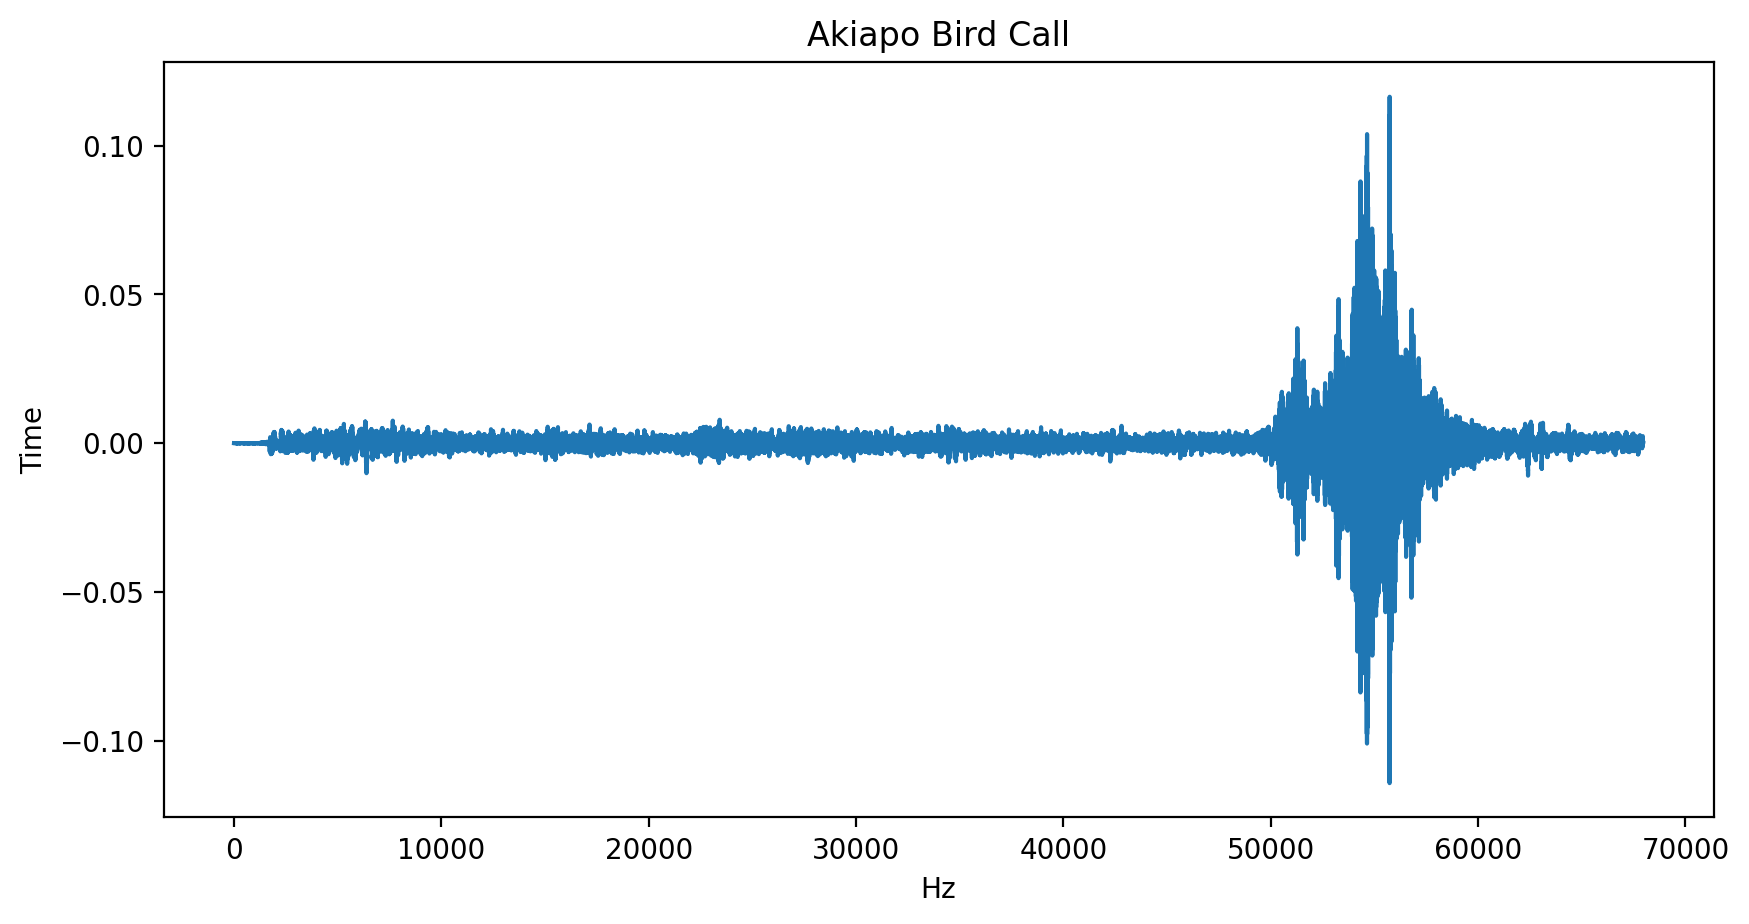

In [365]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(hz)
plt.xlabel('Hz')
plt.ylabel('Time')
plt.title('Akiapo Bird Call');

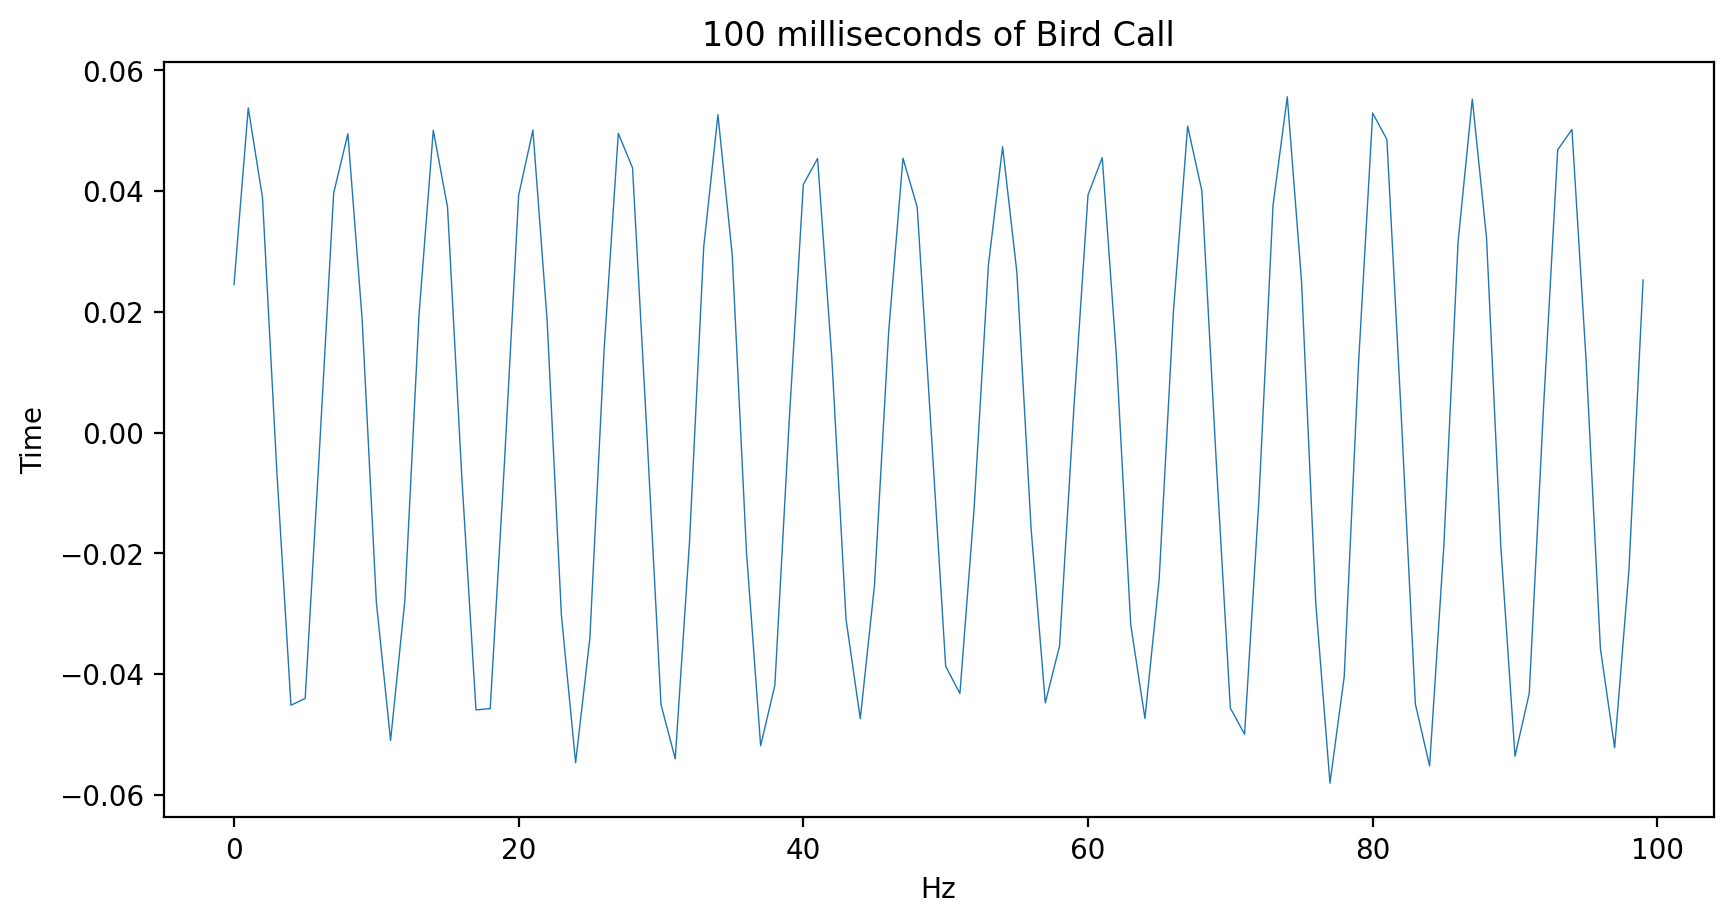

In [366]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(hz[55000:55100], lw=0.5)
plt.xlabel('Hz')
plt.ylabel('Time')
plt.title('100 milliseconds of Bird Call');

In [367]:
np.shape(hz)

(67959,)

In [368]:
wave = librosa.feature.melspectrogram(y=hz, sr=srate)

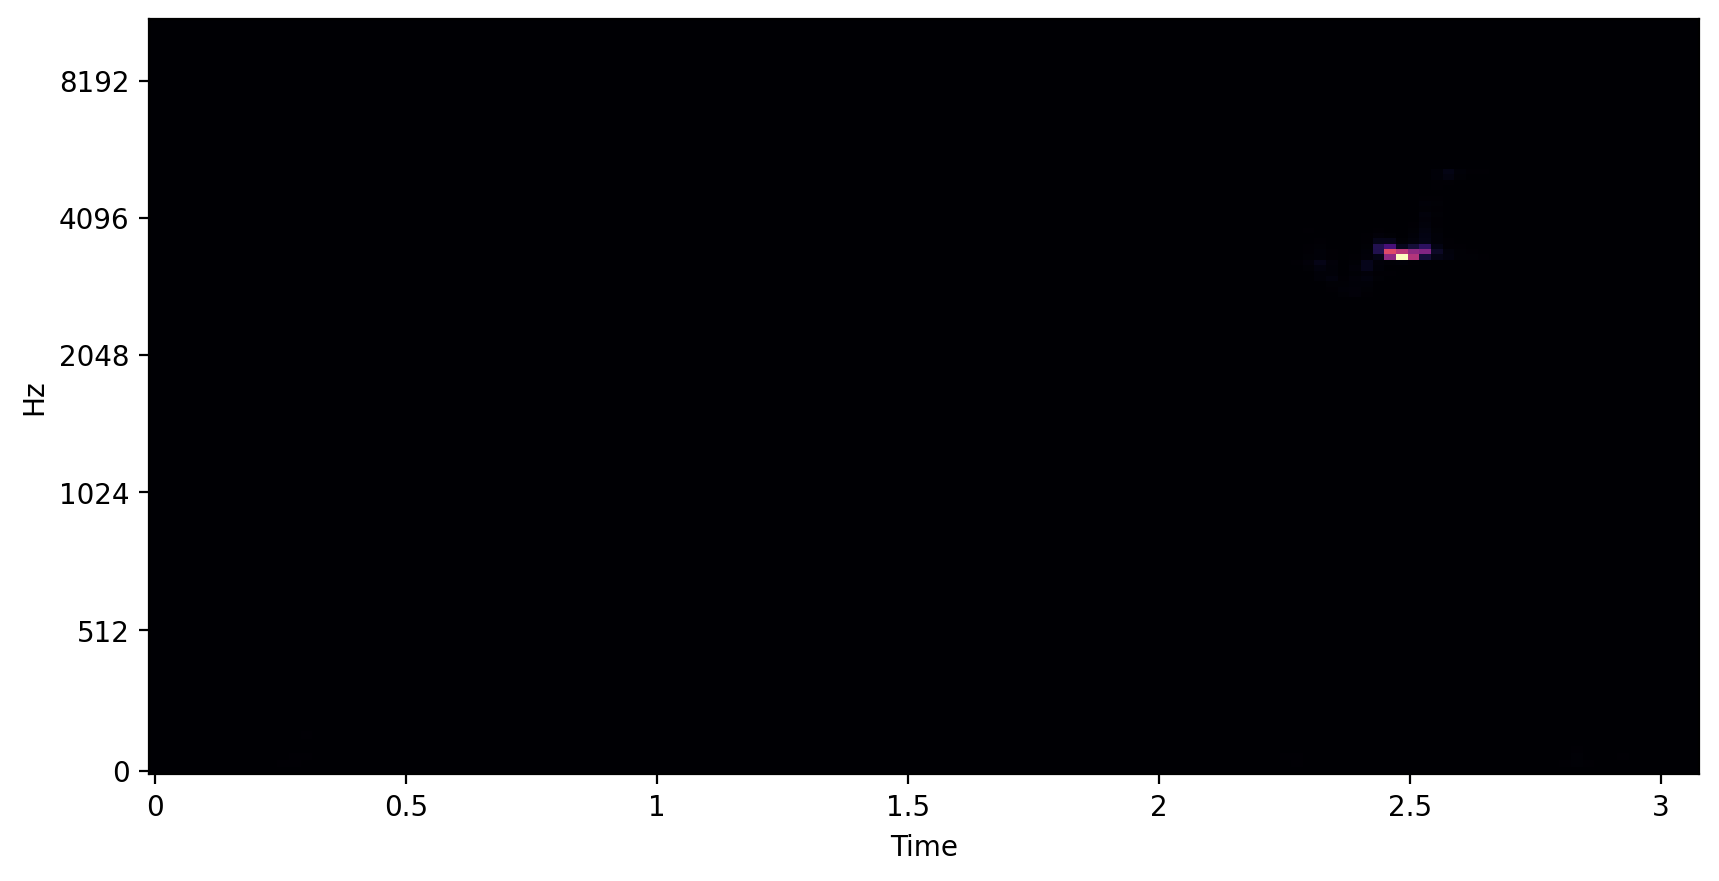

In [369]:
plt.figure(figsize=(10,5), dpi=200)
librosa.display.specshow(wave, y_axis='mel', x_axis='time');

Very distinct footprint here

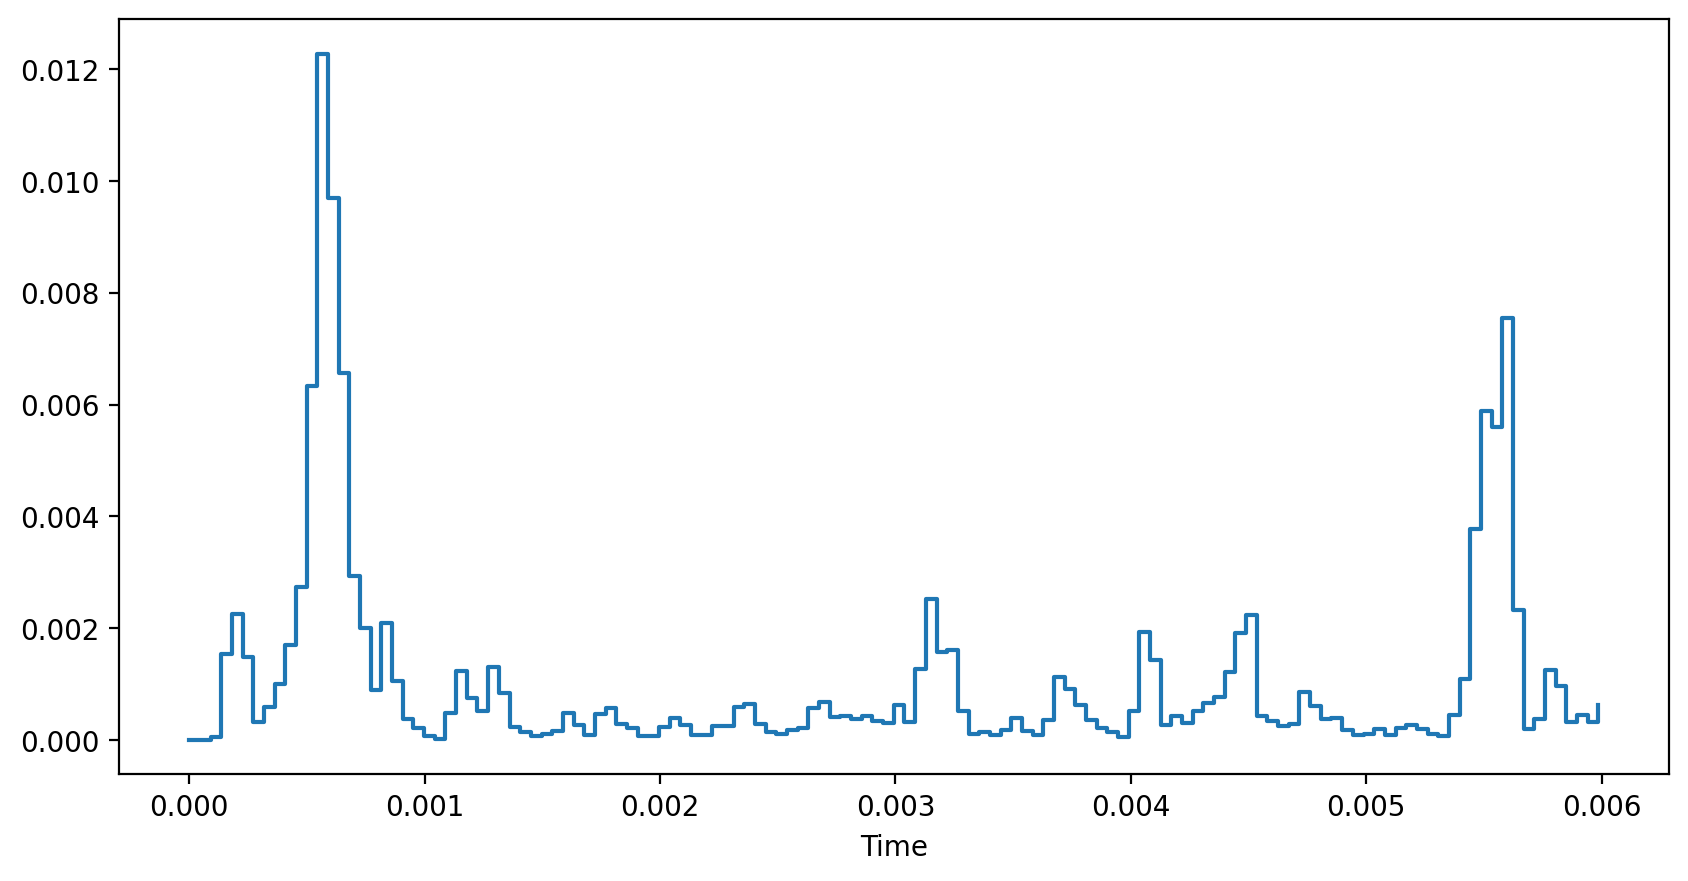

In [370]:
plt.figure(figsize=(10,5), dpi=200)
librosa.display.waveshow(wave, sr=srate); # http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.display.waveplot.html


will try a different library to read raw information, see if its faster....**7.32 versus 116 for librosa!**

In [371]:
%%timeit
data, samplerate = sf.read('./data/birdclef-2022/train_audio/akiapo/XC648120.ogg')

7.71 ms ± 556 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


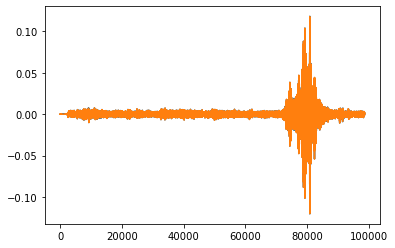

In [372]:
plt.plot(data);

so the idea is for each test audio file, to compare each of the 205 audio files here for the best similarity matrix. To assess the feasibility of that I'll have to demo a single comparison.

these are the highest rated recordings, for each distinct call category for the aniani bird( 3 ) I should be able to compare another birds recordings against the 3 to demonstrate, and the aniani  calls against the remaining recordings for itself since it just comes down to classifying the bird species


In [373]:
df.head(20)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
39,akiapo,[],['begging call (?)'],19.7901,-155.3273,Hemignathus wilsoni,Akiapolaau,Daniel Lane,Creative Commons Attribution-NonCommercial-Sha...,4.0,15:40,https://www.xeno-canto.org/27355,akiapo/XC27355.ogg
42,akiapo,[],['song'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,George Wagner,Creative Commons Attribution-NonCommercial-Sha...,5.0,12:00,https://www.xeno-canto.org/306424,akiapo/XC306424.ogg
45,akiapo,[],"['adult', 'call', 'female']",19.5361,-155.3247,Hemignathus wilsoni,Akiapolaau,Naomi,Creative Commons Attribution-NonCommercial-Sha...,4.0,10:30,https://www.xeno-canto.org/648120,akiapo/XC648120.ogg
102,aniani,[],['call'],22.1467,-159.6134,Magumma parva,Anianiau,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,5.0,15:30,https://www.xeno-canto.org/210202,aniani/XC210202.ogg
103,aniani,[],['call'],22.1467,-159.6134,Magumma parva,Anianiau,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,09:00,https://www.xeno-canto.org/210203,aniani/XC210203.ogg
104,aniani,[],['call'],22.1467,-159.6134,Magumma parva,Anianiau,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,09:00,https://www.xeno-canto.org/210204,aniani/XC210204.ogg
105,aniani,[],['call'],22.1467,-159.6134,Magumma parva,Anianiau,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/210205,aniani/XC210205.ogg
106,aniani,[],['song'],22.1467,-159.6134,Magumma parva,Anianiau,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,5.0,15:00,https://www.xeno-canto.org/210206,aniani/XC210206.ogg
107,aniani,[],"['call', 'rain']",22.1493,-159.6099,Magumma parva,Anianiau,Bobby Wilcox,Creative Commons Attribution-NonCommercial-Sha...,2.0,11:30,https://www.xeno-canto.org/256222,aniani/XC256222.ogg
109,aniani,[],['call'],22.1493,-159.6099,Magumma parva,Anianiau,Bobby Wilcox,Creative Commons Attribution-NonCommercial-Sha...,0.0,15:00,https://www.xeno-canto.org/314503,aniani/XC314503.ogg


In [374]:
# source for doc https://pysoundfile.readthedocs.io/en/latest/

In [375]:
aniani1, anianisr1 = sf.read('./data/birdclef-2022/train_audio/aniani/XC210206.ogg')
aniani2, anianisr2 = sf.read('./data/birdclef-2022/train_audio/aniani/XC256222.ogg')
aniani3, anianisr3 = sf.read('./data/birdclef-2022/train_audio/aniani/XC314503.ogg')
aniani4, anianisr4 = sf.read('./data/birdclef-2022/train_audio/aniani/XC210202.ogg')
aniani5, anianisr5 = sf.read('./data/birdclef-2022/train_audio/aniani/XC210203.ogg')
aniani6, anianisr6 = sf.read('./data/birdclef-2022/train_audio/aniani/XC210204.ogg')
aniani7, anianisr7 = sf.read('./data/birdclef-2022/train_audio/aniani/XC210205.ogg')
aniani8, anianisr8 = sf.read('./data/birdclef-2022/train_audio/aniani/XC317139.ogg')

In [376]:
akiapo1, akiaposr1 = sf.read('./data/birdclef-2022/train_audio/akiapo/XC648120.ogg')
akiapo2, akiaposr2 = sf.read('./data/birdclef-2022/train_audio/akiapo/XC27355.ogg')
akiapo3, akiaposr3 = sf.read('./data/birdclef-2022/train_audio/akiapo/XC306424.ogg')

Okay I guess librosa probably converts the raw waveform to herz cause its a 1 d array versus what I'm getting here being 2 d'

In [377]:
aniani1, anianisr1 = librosa.load('./data/birdclef-2022/train_audio/aniani/XC210206.ogg')
aniani2, anianisr2 = librosa.load('./data/birdclef-2022/train_audio/aniani/XC256222.ogg')
aniani3, anianisr3 = librosa.load('./data/birdclef-2022/train_audio/aniani/XC314503.ogg')
aniani4, anianisr4 = librosa.load('./data/birdclef-2022/train_audio/aniani/XC210202.ogg')
aniani5, anianisr5 = librosa.load('./data/birdclef-2022/train_audio/aniani/XC210203.ogg')
aniani6, anianisr6 = librosa.load('./data/birdclef-2022/train_audio/aniani/XC210204.ogg')
aniani7, anianisr7 = librosa.load('./data/birdclef-2022/train_audio/aniani/XC210205.ogg')
aniani8, anianisr8 = librosa.load('./data/birdclef-2022/train_audio/aniani/XC317139.ogg')
akiapo1, akiaposr1 = librosa.load('./data/birdclef-2022/train_audio/akiapo/XC648120.ogg')
akiapo2, akiaposr2 = librosa.load('./data/birdclef-2022/train_audio/akiapo/XC27355.ogg')
akiapo3, akiaposr3 = librosa.load('./data/birdclef-2022/train_audio/akiapo/XC306424.ogg')

for the reference call, the white noise needs to be clipped out if using the fast pattern matching function, which is at index 500000 to 600000

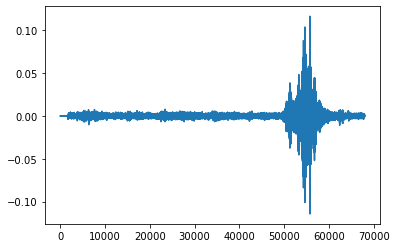

In [378]:
plt.plot(akiapo1);

In [379]:
akiapo1 = akiapo1[50000:60000]

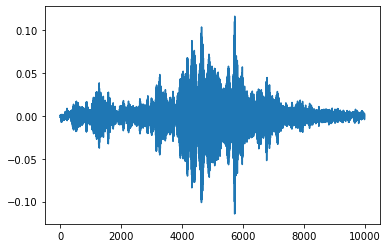

In [380]:
plt.plot(akiapo1);

Searches akiapo file 3 for refence call

In [381]:
distance_profile = stumpy.mass(akiapo1, akiapo3)

AS the test data has 20 possible birds, the pattern search would take a minute to compute each profile for a sound bit in the test data (on my computer).

The test data contains 5,500 recordings, each a minute long. so the runtime would be too long. The library has a GPU version however, and with better hardware it might be much lower

[tutorial](https://stumpy.readthedocs.io/en/latest/Tutorial_Pattern_Matching.html) used for pattern matching

Here the nearest match to the bird call1, within the sequence of calls3 index position is stored

In [382]:
match_loc = np.argmin(distance_profile)

The distance profile takes z-normalized distance so original data needs to be transformed to represent on the same plot

In [383]:
akiapo1_z = stumpy.core.z_norm(akiapo1)
akiapo3_z = stumpy.core.z_norm(akiapo3[match_loc:(match_loc+len(akiapo1))])

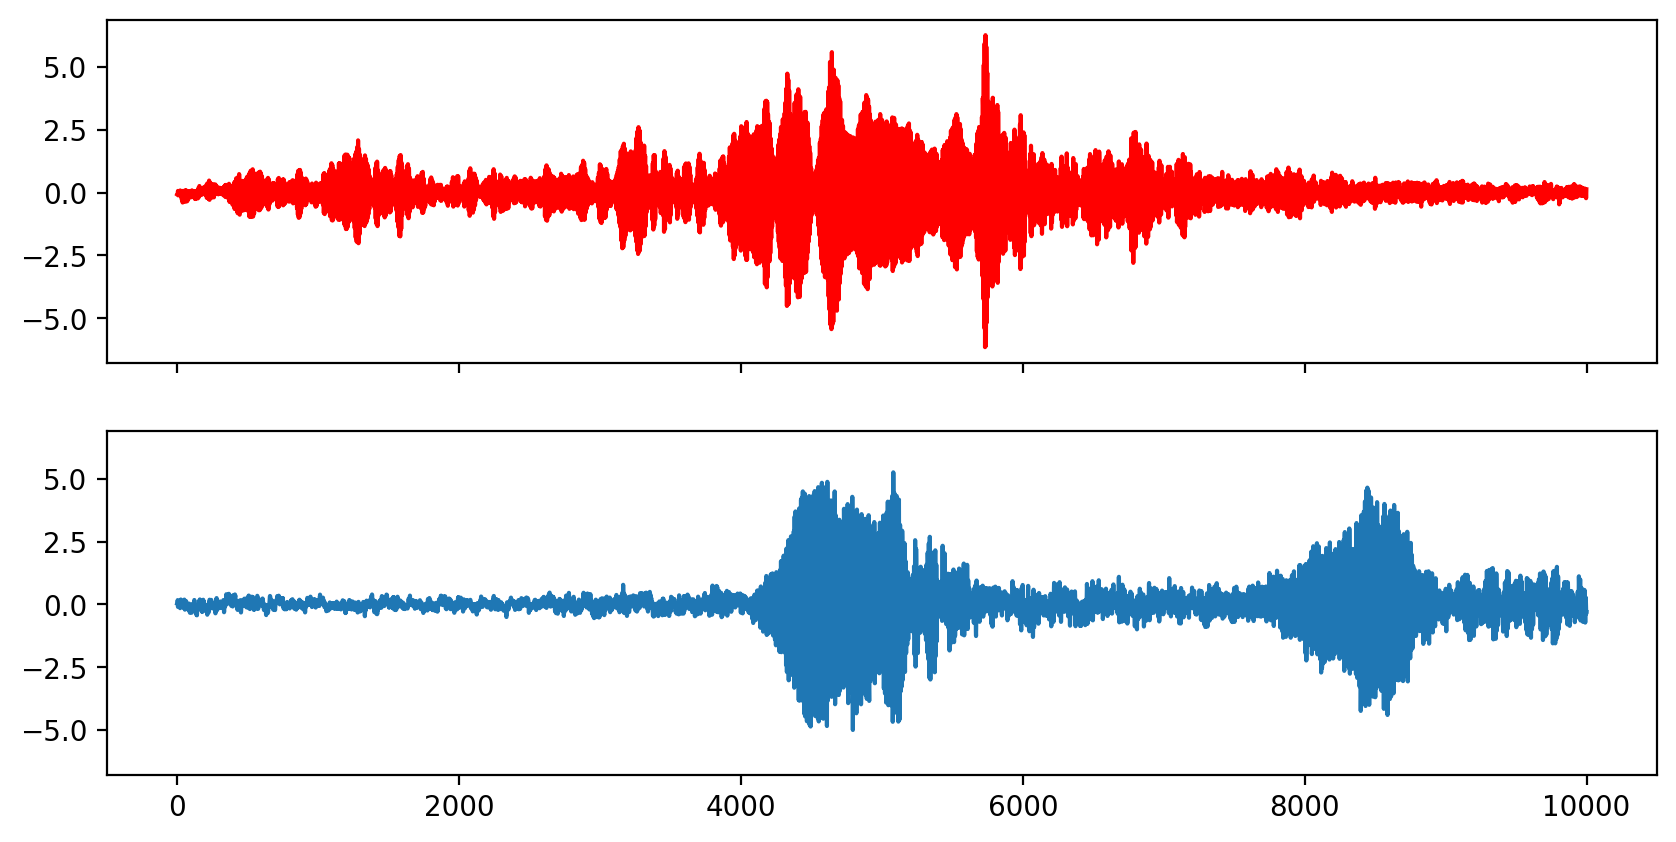

In [394]:

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=((10,5)), dpi=200)
ax[0].plot(akiapo1_z, color='red', label='Akiapo Reference Call')
ax[1].plot(akiapo3_z, label='Akiapo Song');


The reference is a call, whereas a song is searched but the profile minima end up being lower (more similar) than when the call is searched for a different type of birds song as shown below

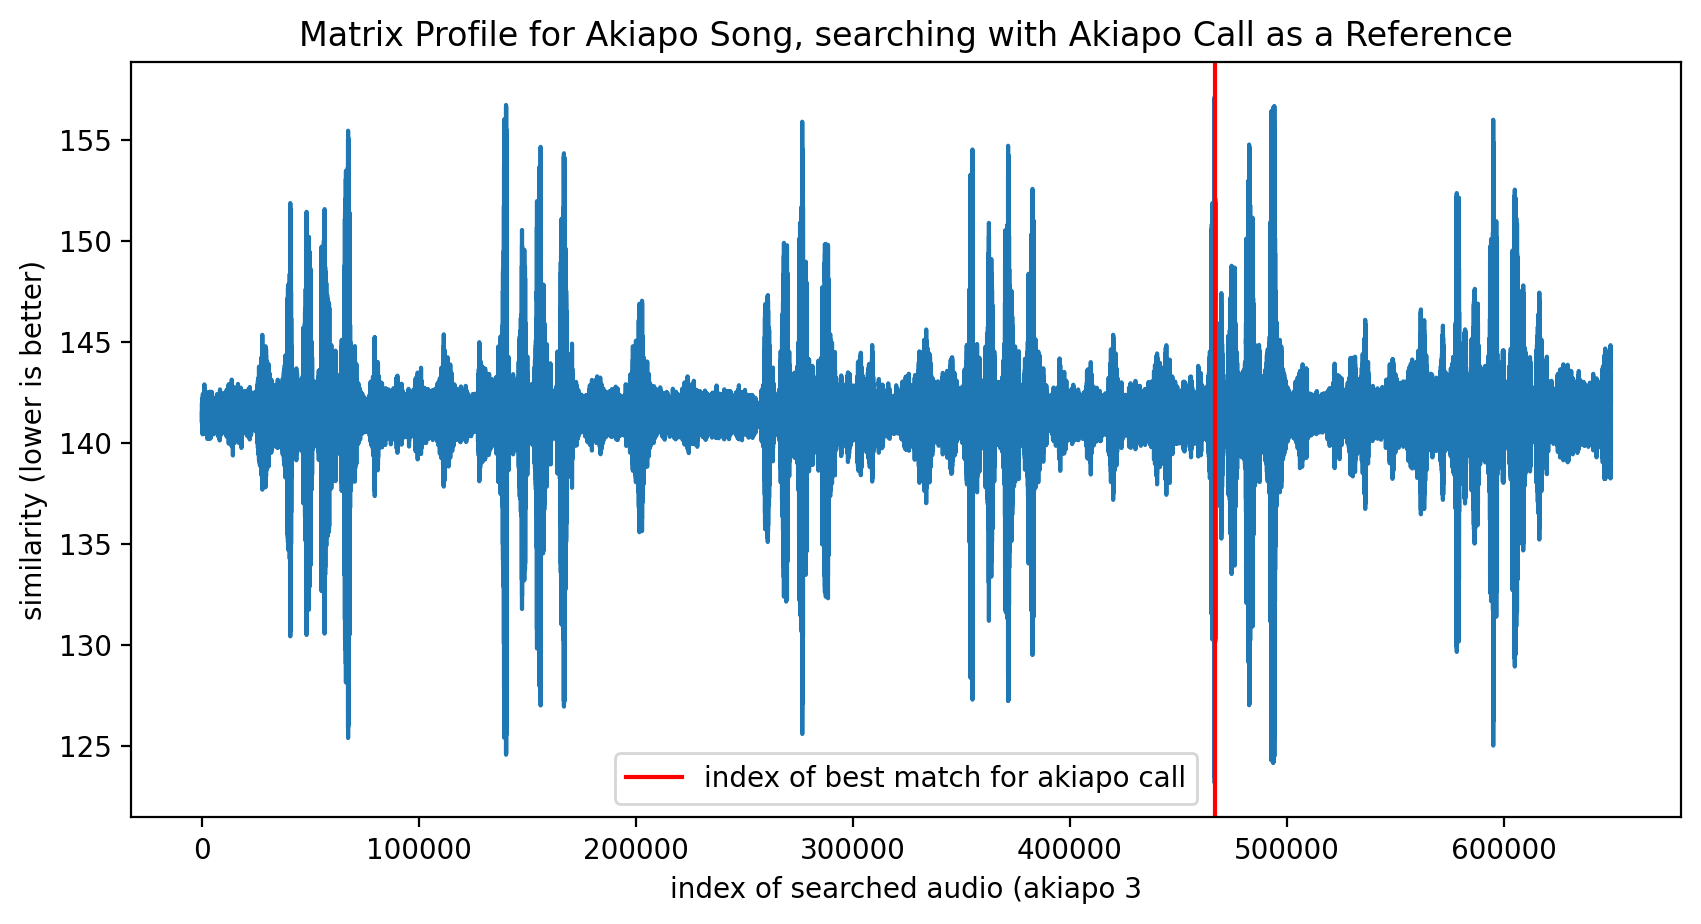

In [385]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(distance_profile)
plt.xlabel('index of searched audio (akiapo 3')
plt.ylabel('similarity (lower is better)')
plt.title('Matrix Profile for Akiapo Song, searching with Akiapo Call as a Reference')
plt.axvline(x=(match_loc), color = 'red', label='index of best match for akiapo call')
plt.legend();


- As you can see, this sequence of the akiapo song is most similar to the akiapo call, since the global minima for the profile occurs in this sequence of the song.
- When the call is compared to segments of white noise, the score is not as low indicating a lower similarty

## Now search for the akiapo call in a aniani bird recording

In [386]:
distance_profile = stumpy.mass(akiapo1, aniani1)
match_loc = np.argmin(distance_profile)

In [387]:
akiapo1_z = stumpy.core.z_norm(akiapo1)
aniani1_z = stumpy.core.z_norm(aniani1[match_loc:(match_loc+len(akiapo1))])

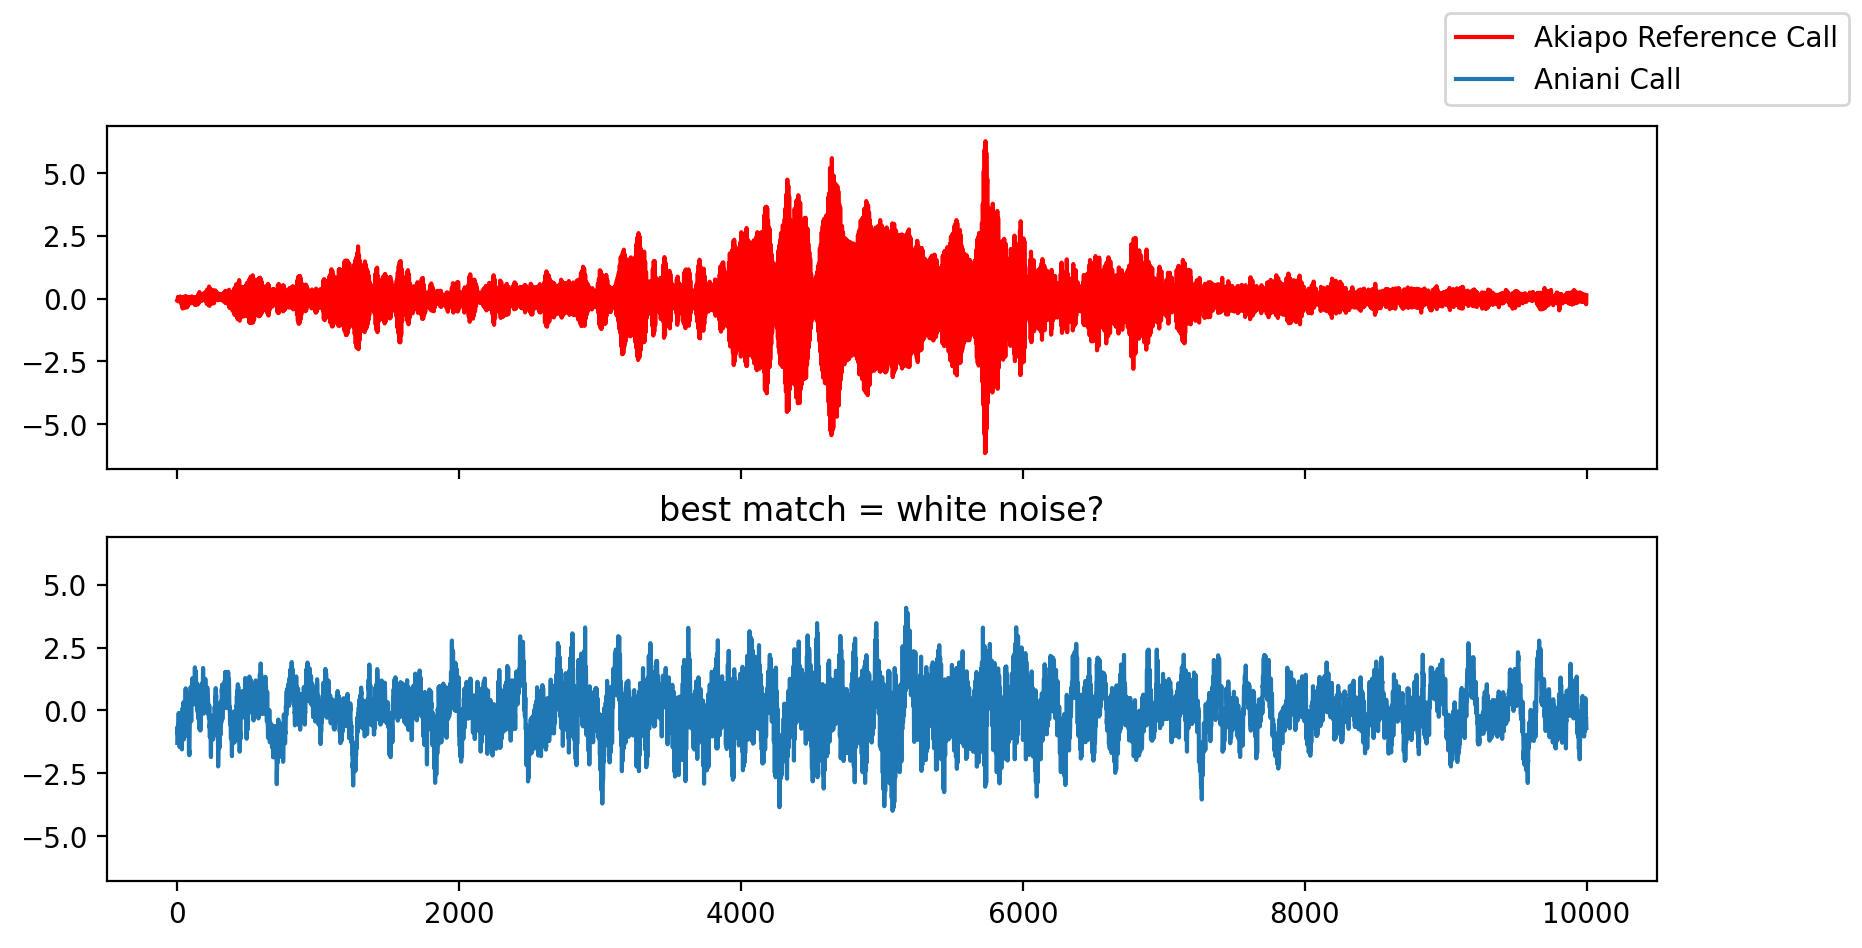

In [388]:

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,5), dpi=200)
ax[0].plot(akiapo1_z, color='red', label='Akiapo Reference Call')
ax[1].plot(aniani1_z, label='Aniani Call')
fig.legend()
plt.title('best match = white noise?');

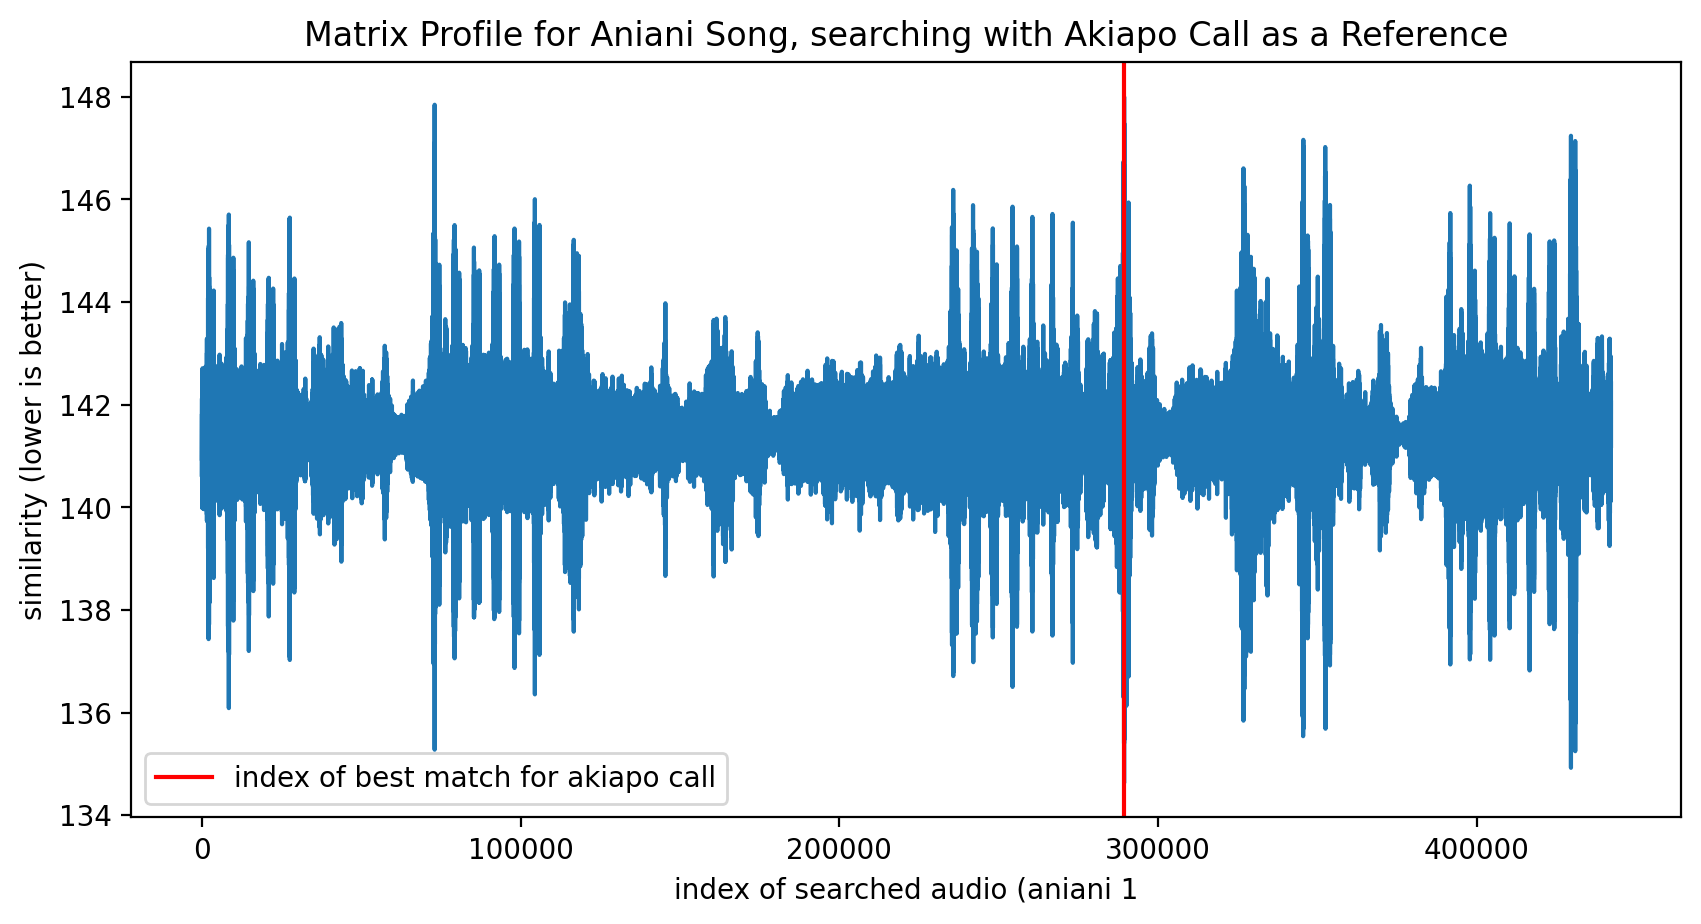

In [389]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(distance_profile)
plt.xlabel('index of searched audio (aniani 1')
plt.ylabel('similarity (lower is better)')
plt.title('Matrix Profile for Aniani Song, searching with Akiapo Call as a Reference')
plt.axvline(x=(match_loc), color = 'red', label='index of best match for akiapo call')
plt.legend();

**The best match for the akiapo occurs during some white noise, while the minima for the profile only reach 136, while the first profile reaches down to 125. Both had a centerpoint of 141 so this indicates the match is better for the akiapo vs akiapo profile (as it should)**



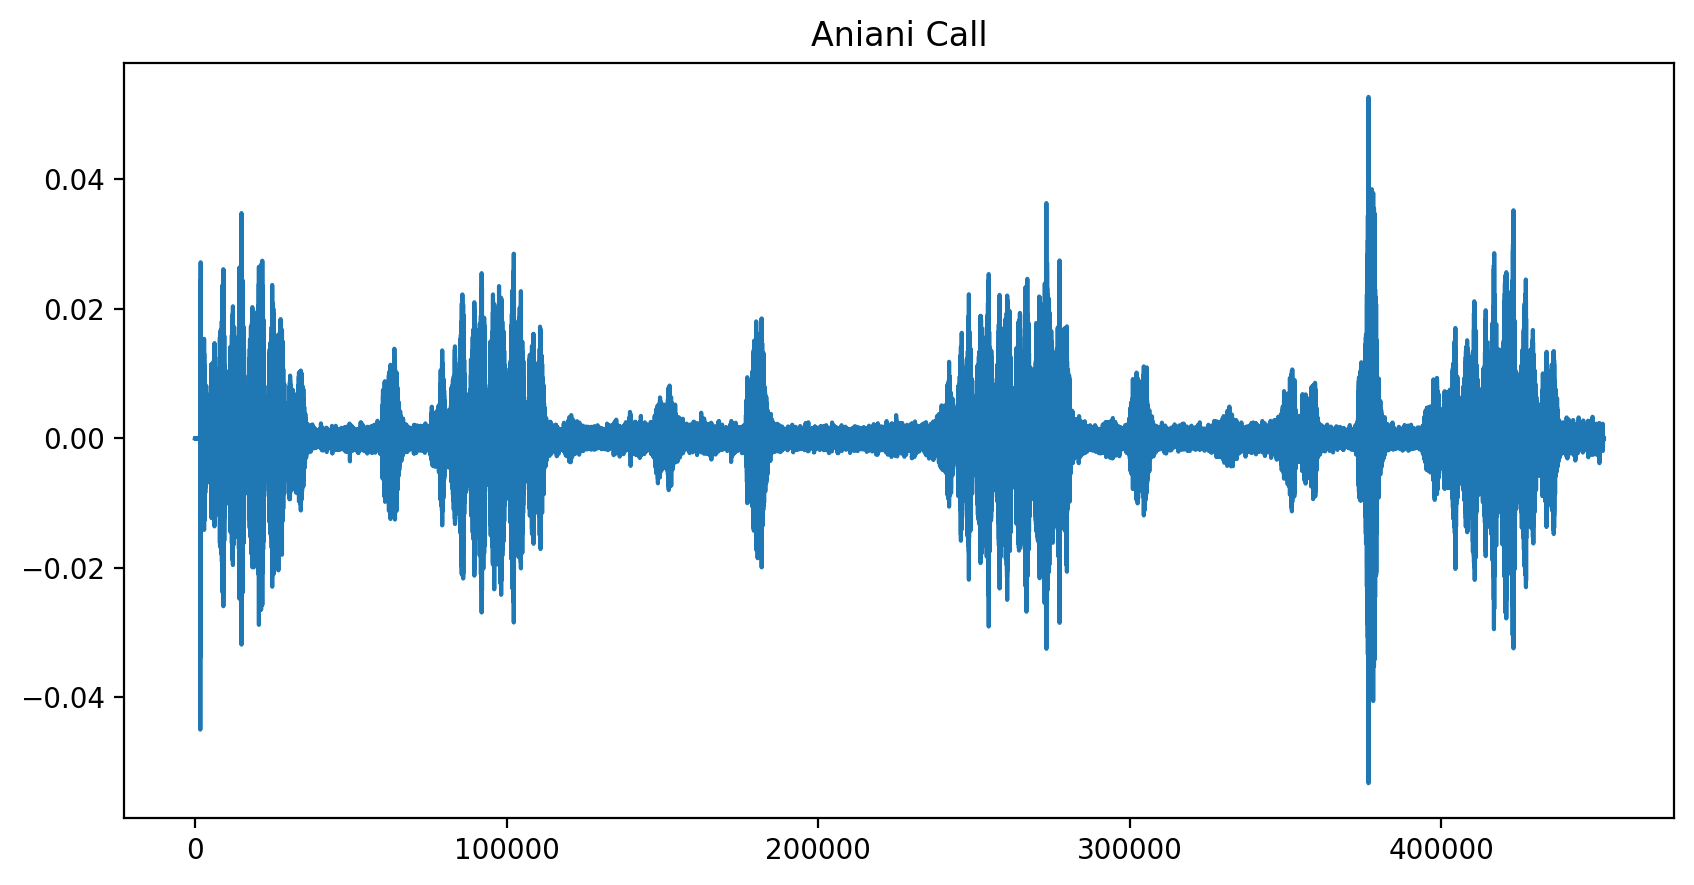

In [390]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(aniani1)
plt.title('Aniani Call');

## in summary:

<p style="line-height:2">

the fast pattern matching function of stumpy took a short amount of time, given each audio sample was in the hundreds of thousands of data-points. With better hardware and the stumpy-gpu version I think this could be scalable after some refinement of the pre-processing steps.

- The ultimate objective would be to search each of the 5,500 test files, creating a profile for each birds call/song. And the assessing the profile values for the most similar pattern.

- Could be optimized further by honing in or clipping the reference audio files to just the calls, greatly reducing search times.

- Or just by using feature transforming to get the actual frequencies and amplitudes for each time frame.

- I'm limited in my capacity for maniulating these files right now but comparing the two different calls

- seaching the repeated sound file with the single call of the apikapo, the global minima were lower from the baseline of noise at 370, than when the call of the apikapo was searched in the clip of the aniani bird.
</p>